**Roujia Zhong & Luhang Sun**

Fall 2020

CS343: Neural Networks

Project 4: Transfer Learning

In [32]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)
rgen = np.random.RandomState(1)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## TensorFlow install test

*Sanity check that Tensorflow is installed correctly:*

Executing the following cell should return 3 

In [4]:
tf.print(tf.reduce_sum([tf.Variable(1), tf.Variable(2)]))

3


## Task 1: Implement ConvNet4 in TensorFlow

You will construct the familar ConvNet4 neural network architecture from last project in TensorFlow's high level `Keras::Sequential` API. Also like your last project, you will train and test on the STL-10 dataset.

### 1a. Use the high level `Keras::Sequential` API in Tensorflow 2 to implement the architecture of ConvNet4 from the last project. Train and test your network on the STL-10 dataset. 

Recall the `Keras::Sequential` common worflow:

- Build structure of network with `keras::Sequential`.
- Compile network with your choice of optimizer, loss, and metrics.
- Fit the model (remembering to pass in the appropriate training and validation sets). This results a history object that can be used to examine training/validation accuracy and loss.
- Evaluate the model on the test set. This returns test loss and accuracy.

#### Notes

- You should use the usual STL-10 data acquistion and preprocessing code from your last project.
- You don't need to do a hyperparameter search. Values that worked on the CNN project should get you in the ballpark here. The goal is to show that you know how to put together a `keras::Sequential` model and have it work successfully.
- TensorFlow needs the RGB color channel AFTER the spatial dimensions. For example: (64, 64, 3), not (3, 64, 64). You may therefore need to slightly modify the preprocesssing pipeline for this project.

#### Helpful documentation

These documentation pages should be helpful:
- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary

In [4]:
import load_stl10_dataset
import preprocess_data

In [102]:
load_stl10_dataset.purge_cached_dataset()
# preprocess and create splits
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.load_stl10(
    n_train_samps=4398, n_test_samps=400, n_valid_samps=200, n_dev_samps=2, scale_fact=3)

print ('Train data shape: ', x_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('Validation data shape: ', x_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('dev data shape: ', x_dev.shape)
print ('dev labels shape: ', y_dev.shape)

Images are: (5000, 96, 96, 3)
Labels are: (5000,)
Resizing 5000 images to 32x32...Done!
Saving Numpy arrays the images and labels to ./numpy...Done!
Train data shape:  (4398, 3, 32, 32)
Train labels shape:  (4398,)
Test data shape:  (400, 3, 32, 32)
Test labels shape:  (400,)
Validation data shape:  (200, 3, 32, 32)
Validation labels shape:  (200,)
dev data shape:  (2, 3, 32, 32)
dev labels shape:  (2,)


In [103]:
#reshape the data array so that the color channel is after the spatial dimensions
x_train = np.swapaxes(x_train, 1, 2)
x_train = np.swapaxes(x_train, 2, 3)
x_test = np.swapaxes(x_test, 1, 2)
x_test = np.swapaxes(x_test, 2, 3)
x_val = np.swapaxes(x_val, 1, 2)
x_val = np.swapaxes(x_val, 2, 3)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(4398, 32, 32, 3)
(400, 32, 32, 3)
(200, 32, 32, 3)


In [104]:
#define the number of hidden units
H1 = 100 # num hidden units in L1 (1st hidden layer)
C = 10

In [105]:
model = tf.keras.Sequential(
    [
        
        tf.keras.Input(shape = x_train.shape[1:]),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = H1, activation = 'relu'),
        tf.keras.layers.Dense(units = C, activation = 'softmax'),
        
    ]
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               819300    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
Total params: 825,046
Trainable params: 825,046
Non-trainable params: 0
_________________________________________________________________


In [106]:
#compile the network
adam = tf.optimizers.Adam(lr = 1e-4)
model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#sparse_categorical: classes are int-coded

In [107]:
hist = model.fit(x_train, y_train, batch_size = 100, epochs = 100, validation_data = (x_val, y_val))

Epoch 1/100
44/44 [==============================] - 2s 56ms/step - loss: 2.0722 - accuracy: 0.2524 - val_loss: 1.9765 - val_accuracy: 0.2650
Epoch 2/100
44/44 [==============================] - 2s 50ms/step - loss: 1.8181 - accuracy: 0.3492 - val_loss: 1.8750 - val_accuracy: 0.3100
Epoch 3/100
44/44 [==============================] - 2s 47ms/step - loss: 1.7128 - accuracy: 0.3788 - val_loss: 1.7975 - val_accuracy: 0.3400
Epoch 4/100
44/44 [==============================] - 2s 51ms/step - loss: 1.6294 - accuracy: 0.4166 - val_loss: 1.7518 - val_accuracy: 0.3650
Epoch 5/100
44/44 [==============================] - 3s 57ms/step - loss: 1.5591 - accuracy: 0.4445 - val_loss: 1.7002 - val_accuracy: 0.3550
Epoch 6/100
44/44 [==============================] - 2s 56ms/step - loss: 1.4981 - accuracy: 0.4645 - val_loss: 1.6889 - val_accuracy: 0.3600
Epoch 7/100
44/44 [==============================] - 2s 53ms/step - loss: 1.4421 - accuracy: 0.4905 - val_loss: 1.6152 - val_accuracy: 0.3950
Epoch 

### 1b. Make 2 "high quality" plots showing the following

- Training and validation accuracy (y axis) over training epochs (x axis).
- Training and validation loss (y axis) over epochs (x axis).

A high quality plot consists of:
- A useful title
- X and Y axis labels
- A legend

In [108]:
import matplotlib.pyplot as plt

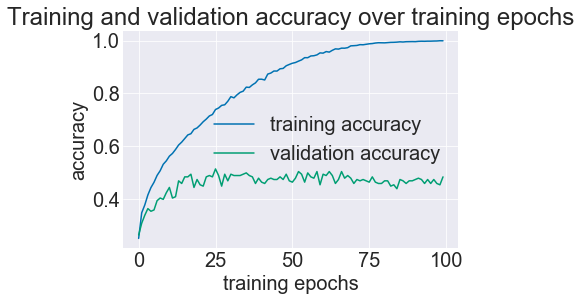

In [109]:
#training and validation accuracy over training epochs
plt.plot(hist.history['accuracy'], label = 'training accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy over training epochs')
plt.show()

In [114]:
#print out the maximum validation accuracy
print('Maximum validation accuracy: ', np.max(hist.history['val_accuracy']))

Maximum validation accuracy:  0.5149999856948853


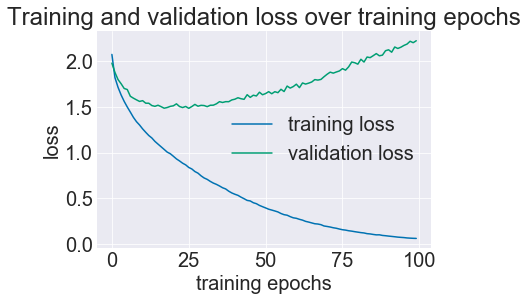

In [110]:
#training and validation loss over training epochs
plt.plot(hist.history['loss'], label = 'training loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('loss')
plt.title('Training and validation loss over training epochs')
plt.show()

In [115]:
#print out the minimum validation loss
print('Minimum validation loss: ', np.min(hist.history['val_loss']))

Minimum validation loss:  1.483263373374939


### 1c. Visualize predictions

Make a 5x5 grid of the first 25 images in the test dataset. Label each with the predicted class label string (English label, not an int code).

In [111]:
# Load in the class names
stl_imgs, stl_labels = load_stl10_dataset.load()
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

Found cached numpy arrays the images and labels. Loading them...
Images are: (5000, 32, 32, 3)
Labels are: (5000,)


In [112]:
probs = model.predict(x_test[:25])
preds = classes[y_test[np.argmax(probs, axis=1)]]

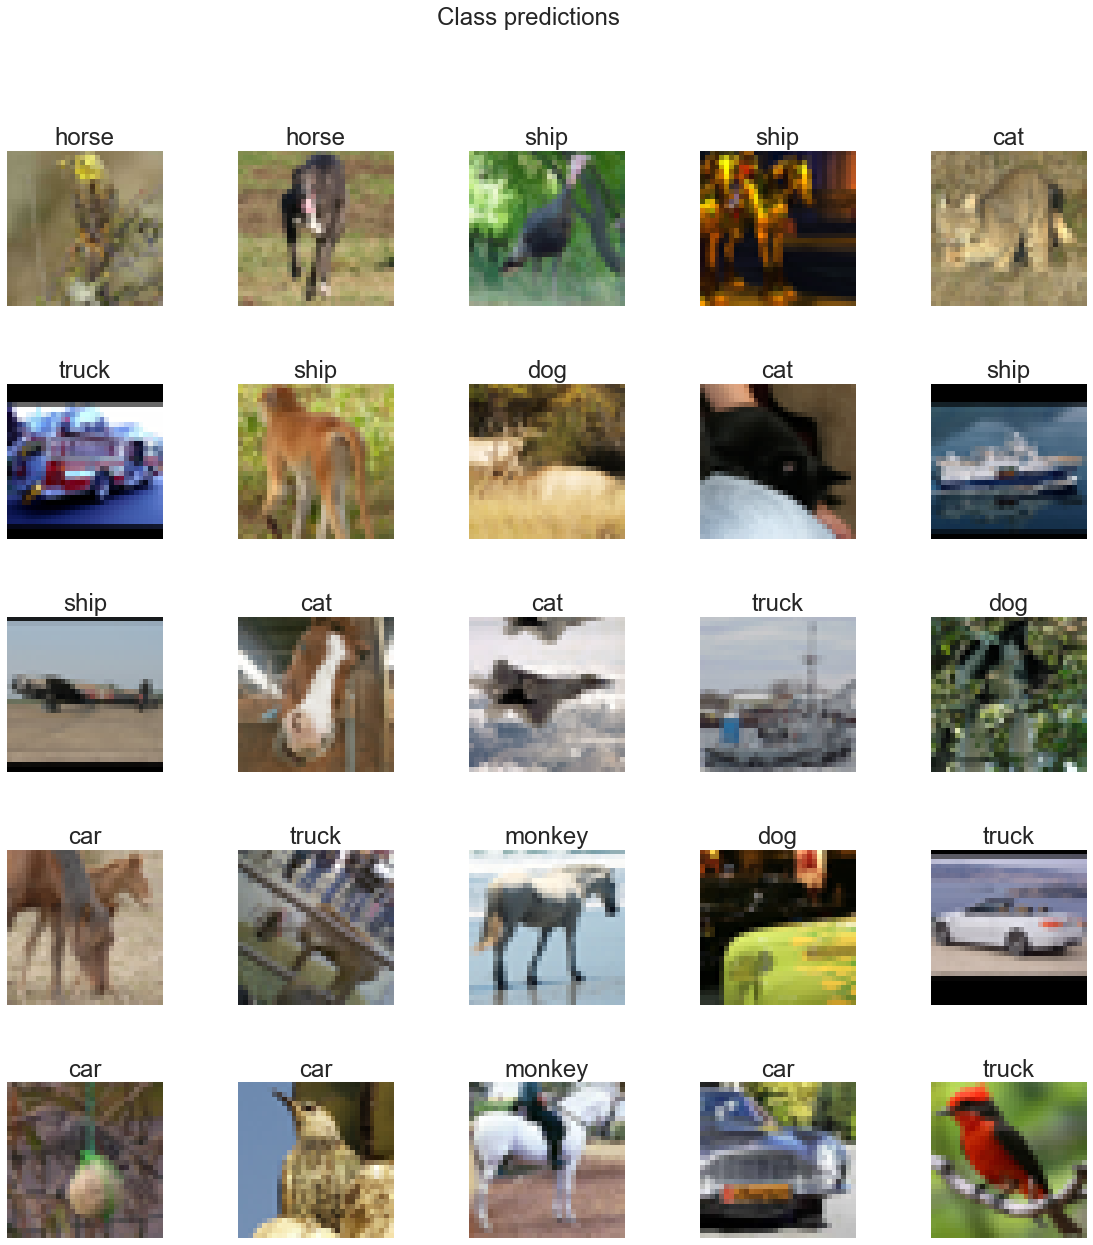

In [113]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(25):
  plt.subplot(5,5,n+1)
  plt.imshow(stl_imgs[n])
  plt.title(preds[n])
  plt.axis('off')
  plt.suptitle("Class predictions")
plt.show()

### 1d. Questions

**Question 1:** What accuracy do you get on the STL-10 test set? Briefly summarize the hyperparameters that you used to obtain this result.

**Question 2:** How do the loss and accurary results compare to the CNN project?

**Question 3:** Identify a few misclassifications. Is there a discernable pattern?

**Answer 1: The highest validation accuracy we got was above 0.5. The final validation accuracy was 0.4850 and the final training accuracy was 0.9991. Here is a list of the hyperparameters we used: filters = 32, kernel_size = 7, pool_size = 2, strides = 2, number of hidden units = 100, learning rate = 0.0004, batch_size = 100, epochs = 100.**

**Answer 2: The highest accuracy results are very similar. Both networks reached around 0.5. Meanwhile, we think that network of this project is slightly overfitting. The accuracy curves of the CNN project increases as the training epochs increases. The loss curve decreases continually. The validation accuracy curve of this project becomes flat in the end. The validation loss curve starts increasing when the number of training epochs is large.**

**Answer 3: We are not sure if there is a discernable pattern. Based on the visualization in 1c, we found that many birds are misclassified as car or truck. Two horses are missclassfied as monkey. A car is misclassfied as a truck. We think that the network might not be able to distinguish car and truck very well.** 

## Task 2: Transfer learning

Here you will use Tensorflow 2 to download the pre-trained MobileNetV2 network (you may also use another network like InceptionV3, but MobileNetV2 likely will run noticeably faster on your machine). We will use transfer learning to accelerate training to solve a novel problem: **the binary classification task of discriminating whether an image is of a hotdog or not.**

### Overview

- Remove the output layer, add a new Dense output layer.
- Freeze (disable) training on all non-output layers.
- Train the last layer on a food dataset. Assess performance. Plot some example images and their classification below.

### 2a. Download and load in hotdot image dataset

Download the **food dataset** from the project website, copy it into a `data` subfolder in your project directory.

Run the below code to load in the hot-dog-or-not dataset. Check the shapes to ensure everything is loaded in correctly. 

In [47]:
ds_base_dir = 'data/hot-dog-not-hot-dog/numpy/'
hotdog_train_x = np.load(os.path.join(ds_base_dir, 'train_x.npy'))
hotdog_train_y = np.load(os.path.join(ds_base_dir, 'train_y.npy'))
hotdog_test_x = np.load(os.path.join(ds_base_dir, 'test_x.npy'))
hotdog_test_y = np.load(os.path.join(ds_base_dir, 'test_y.npy'))

print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (16000, 96, 96, 3)')
print(f'Test hotdog split shape: {hotdog_test_x.shape}. Should be (4000, 96, 96, 3)')

Training hotdog split shape: (16000, 96, 96, 3). Should be (16000, 96, 96, 3)
Test hotdog split shape: (4000, 96, 96, 3). Should be (4000, 96, 96, 3)


#### Visualize data

Write code below to view (plot) some of the images in the dataset. It is always important to look at your data!

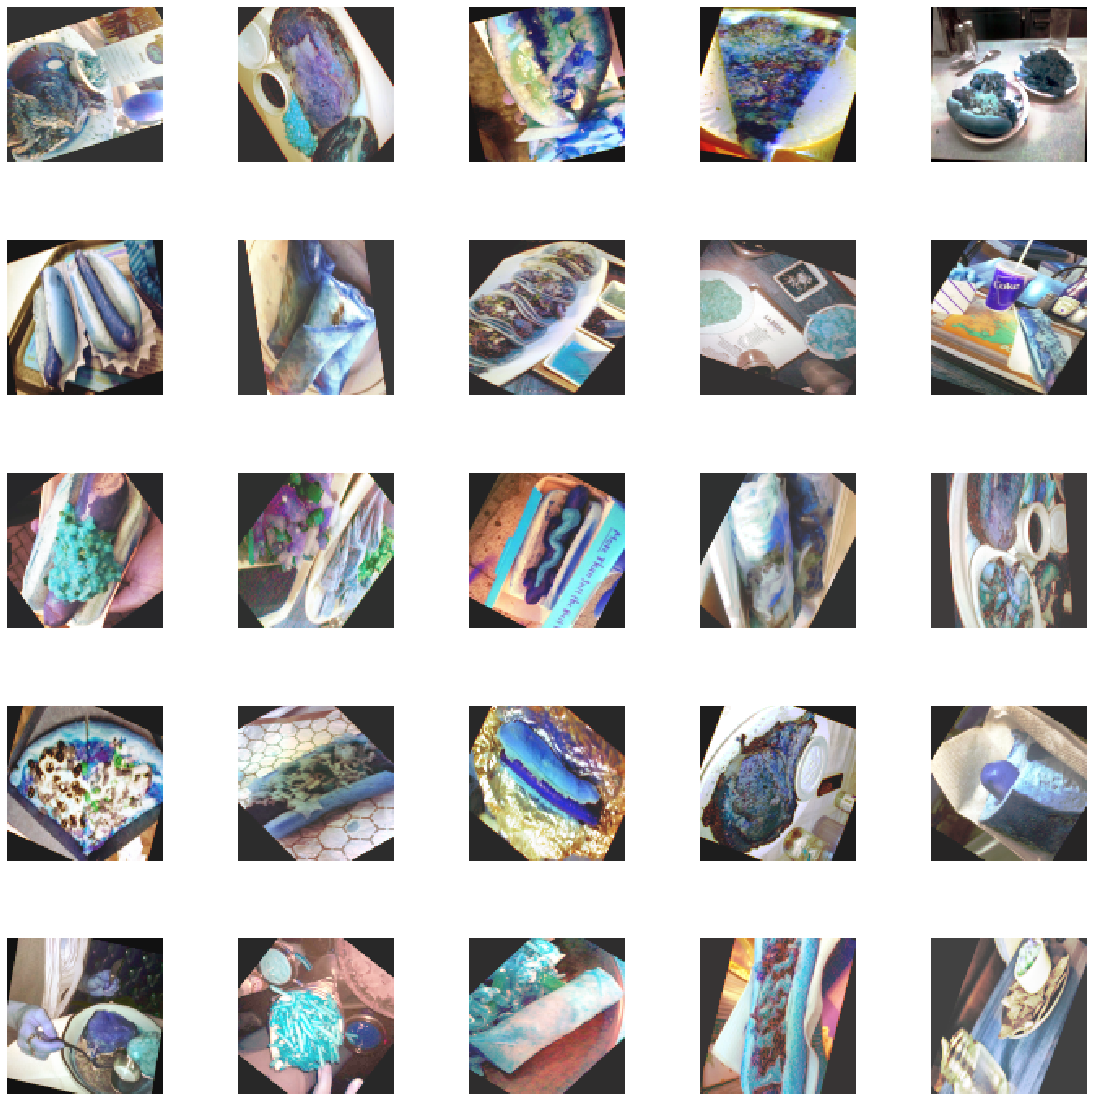

In [46]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(25):
  plt.subplot(5,5,n+1)
  plt.imshow(hotdog_train_x[n])
  plt.axis('off')
plt.show()

### 2b. Normalize hotdog dataset

Normalize the train and test dataset by standardizing both based on the training set statistics.

In [48]:
#training set statistics
normalized_train_x = (hotdog_train_x - np.mean(hotdog_train_x, axis = 0))/ np.std(hotdog_train_x, axis = 0)
normalized_test_x = (hotdog_test_x - np.mean(hotdog_train_x, axis = 0))/ np.std(hotdog_train_x, axis = 0)

### 2c. Create hotdog validation set

Set aside the last 20% of the training set as the validation set

In [49]:
num_data = len(hotdog_train_y)
training_num_data = int(num_data * 0.8)
hotdog_val_x = normalized_train_x[training_num_data:]
hotdog_val_y = hotdog_train_y[training_num_data:]
hotdog_train_x = normalized_train_x[:training_num_data]
hotdog_train_y = hotdog_train_y[:training_num_data]
print(f'Validation hotdog split shape: {hotdog_val_x.shape}. Should be (3200, 96, 96, 3)')
print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (12800, 96, 96, 3)')

Validation hotdog split shape: (3200, 96, 96, 3). Should be (3200, 96, 96, 3)
Training hotdog split shape: (12800, 96, 96, 3). Should be (12800, 96, 96, 3)


### 2d. Load in pre-trained MobileNetV2 network.

Load in a pre-trained MobileNetV2 network (look up constructor in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications) or look at the tutorial from class) and set it to a variable called `model`. Remember to make the network not trainable. Calling the `summary()` method on the network object should show you a table with many rows. The top and bottom rows should be:


    input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                           
    __________________________________________________________________________________________________
    out_relu (ReLU)                 (None, 3, 3, 1280)   0           Conv_1_bn[0][0]  

and you should see the following at the bottom:

    Total params: 2,257,984
    Trainable params: 0
    Non-trainable params: 2,257,984

In [50]:
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [51]:
#load in a pre-trained MibileNetV2 network
input_nonbatch_shape = hotdog_train_x.shape[1:]
model = tf.keras.applications.MobileNetV2(input_shape=input_nonbatch_shape, weights='imagenet')
model.trainable = False
model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

### 2e. Create augmented model

Create a new `keras::Sequential` augmented model with an output layer that has the correct number of units to deal with the hot-dog or not problem 

Compile the augmented model with
- Adam optimizer (learning rate of 0.0001)
- binary_crossentropy loss
- accuracy metric. 

Here is the final part of the summary from the augmented model that you should get:

    Total params: 2,269,505
    Trainable params: 11,521
    Non-trainable params: 2,257,984

#### Helpful links

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam https://www.tensorflow.org/api_docs/python/tf/losses

In [64]:
#create a new augmented model with an output layer
model = tf.keras.applications.MobileNetV2(input_shape=input_nonbatch_shape,include_top=False,weights='imagenet')
model.trainable = False
model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [65]:
aug_model = tf.keras.Sequential(
    [
        model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ]
)
aug_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11521     
Total params: 2,269,505
Trainable params: 11,521
Non-trainable params: 2,257,984
_________________________________________________________________


In [66]:
adam = tf.optimizers.Adam(lr = 1e-4)
aug_model.compile(optimizer=adam,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
aug_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11521     
Total params: 2,269,505
Trainable params: 11,521
Non-trainable params: 2,257,984
_________________________________________________________________


In [67]:
#Evaluate accuracy with untrained classification layer
loss, acc = aug_model.evaluate(normalized_test_x, hotdog_test_y, verbose=0)
print(f'Accuracy: {acc}, Loss: {loss}')

Accuracy: 0.49900001287460327, Loss: 0.9430009722709656


### 2f. Questions

**Question 4:** What is the accuracy and loss for the network with the untrained output layer on the test set? Explain why you got the accuracy value that you did.

**Question 5:** Briefly defend your choice of number of units in the output layer.

**Answer 4: The accuracy is 0.499 and the loss is 0.943. We got almost 50% of the predictions correct with the untrained network because there are only two classes in this model. For each sample, there is 50% probability of getting the prediction right by chance.**

**Answer 5: Our choice of number of units in the output layer is 1 because this is a binary classification problem and we only need one unit to output either 1 or 0.** 

### 2g. Fit the augmented model on the hotdog training data

Setting the verbose optional parameter to 2 will give you helpful printouts of performance on the validation set as it completes every epoch of training.

#### Training goal

You should aim to achieve at least 75% accuracy on the validation set.


#### Note

If training time is taking much more than a few minutes per epoch on your computer, you could try reducing the number of data samples in train and validation. For example, by default train `N = 12800`. Try `N = 6400` instead. You could do the same for the validation set.

In [60]:
hist = aug_model.fit(hotdog_train_x, hotdog_train_y,
                     epochs=25,
                     verbose=2,
                     batch_size=50,
                     validation_data = (hotdog_val_x, hotdog_val_y))

Epoch 1/25
256/256 - 59s - loss: 0.4924 - accuracy: 0.7637 - val_loss: 0.3872 - val_accuracy: 0.8181
Epoch 2/25
256/256 - 59s - loss: 0.3417 - accuracy: 0.8454 - val_loss: 0.3313 - val_accuracy: 0.8431
Epoch 3/25
256/256 - 62s - loss: 0.2880 - accuracy: 0.8737 - val_loss: 0.3017 - val_accuracy: 0.8678
Epoch 4/25
256/256 - 61s - loss: 0.2510 - accuracy: 0.8962 - val_loss: 0.2837 - val_accuracy: 0.8763
Epoch 5/25
256/256 - 61s - loss: 0.2236 - accuracy: 0.9126 - val_loss: 0.2686 - val_accuracy: 0.8822
Epoch 6/25
256/256 - 67s - loss: 0.2035 - accuracy: 0.9221 - val_loss: 0.2572 - val_accuracy: 0.8903
Epoch 7/25
256/256 - 65s - loss: 0.1849 - accuracy: 0.9337 - val_loss: 0.2457 - val_accuracy: 0.8981
Epoch 8/25
256/256 - 63s - loss: 0.1699 - accuracy: 0.9422 - val_loss: 0.2384 - val_accuracy: 0.9028
Epoch 9/25
256/256 - 63s - loss: 0.1571 - accuracy: 0.9499 - val_loss: 0.2345 - val_accuracy: 0.9050
Epoch 10/25
256/256 - 64s - loss: 0.1472 - accuracy: 0.9551 - val_loss: 0.2303 - val_accura

In [61]:
#evaluate on the test set
loss, acc = aug_model.evaluate(normalized_test_x, hotdog_test_y, verbose=0)
print(f'Accuracy: {acc}, Loss: {loss}')

Accuracy: 0.9237499833106995, Loss: 0.20070262253284454


### 2h. Plot hotdog results

Produce 2 high quality plots showing the following:

- Training and validation loss over epoch.
- Training and validation accuracy over epoch.

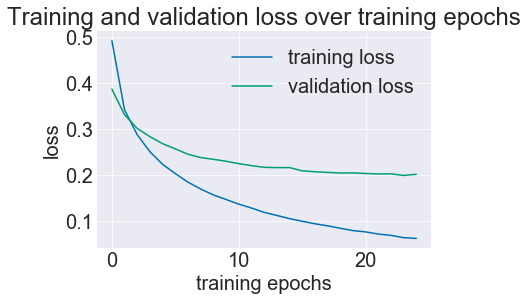

In [62]:
#Training and validation loss over epoch
plt.plot(hist.history['loss'], label = 'training loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('loss')
plt.title('Training and validation loss over training epochs')
plt.show()

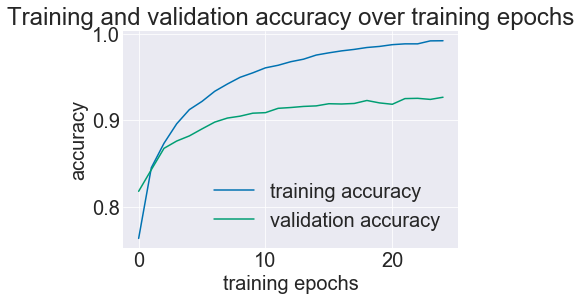

In [63]:
#Training and validation accuracy over epoch
plt.plot(hist.history['accuracy'], label = 'training accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy over training epochs')
plt.show()

### 2i. Questions

**Question 6:** What is the best accuracy that you are able to achieve on the test set? Briefly summarize the hyperparameters that were used in your model.

**Answer 6: The best accuracy is 0.92. Here is a list of the hyperparameters I used: learning rate = 0.0001, epochs = 25, batch size = 50, output unit = 1.** 
